# Построение прогноза временного ряда с использованием изученных методов

## Содержание

* [Подготовка](#prepare)
  * [Загрузка данных](#data_load)
  * [EDA](#eda)
  * [Признаки](#features)
  * [Разложение ВР на компоненты](#decomp)
  * [Стационарность ВР](#stationary)
  * [Скользящие средние для выявления тренда и выбосов](#ma_trend)
  * [Тест Дикки-Фуллера](#test_df)
  * [ACF и PACF](#acf)
* [Моделирование](#model)
  * [Подготовка данных](#train_test)
  * [Functions](#func)
  * [Baseline model](#baseline)
  * [Метрики](#metrics)
  * [ARIMA (без сезонности)](#arima_base)
  * [Подбор оптимальных параметров для ARIMA](#arima_param)
  * [SARIMA. Сезонность 24 часа](#sarima_24)
  * [SARIMA. Сезонность 7 дней](#sarima_7d)
  * [SARIMAX. Экзогенный фактор](#sarimax)
  * [AutoARIMA](#auto_arima)
  * [AutoTBATS](#auto_tbats)
  * [ETNA CatBoost](#etna_catboost)
  * [ETNA TFTModel](#etna_tft)
* [Итог](#summary)

## Подготовка <a class="anchor" id="prepare">#</a>

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoTBATS
from statsforecast.arima import arima_string

from pyts.datasets import load_gunpoint
from pyts.classification import TSBF

from etna.analysis import plot_backtest, plot_trend
from etna.datasets import TSDataset
from etna.metrics import SMAPE, MAPE, MAE, RMSE
from etna.models import CatBoostMultiSegmentModel, CatBoostPerSegmentModel, LinearPerSegmentModel
from etna.models.nn import TFTModel
from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.transforms import DateFlagsTransform, FourierTransform, HolidayTransform, YeoJohnsonTransform, LagTransform, LinearTrendTransform, LabelEncoderTransform
from etna.transforms import LogTransform, MeanTransform, SegmentEncoderTransform, DensityOutliersTransform, TreeFeatureSelectionTransform, StandardScalerTransform
from etna.analysis import plot_periodogram, seasonal_plot, stl_plot
from etna.analysis import acf_plot, cross_corr_plot, distribution_plot, plot_correlation_matrix
from etna.analysis import get_anomalies_density, get_anomalies_iqr, get_anomalies_median
from etna.analysis import plot_anomalies

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных<a class="anchor" id="data_load">#</a>

In [3]:
df_src = pd.read_csv("data/Metro_Interstate_Traffic_Volume.csv")
df = df_src[[
    "date_time",        #
    "traffic_volume",   # наша целевая переменная
    "holiday",          # является ли день некоторым праздником
    "temp"              # температура воздуха
]]
# Приведение даты
df["date_time"] = pd.to_datetime(df["date_time"])

df = df.set_index('date_time').sort_index()

df.head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-02 09:00:00,5545,NaN,288.28
2012-10-02 10:00:00,4516,NaN,289.36
2012-10-02 11:00:00,4767,NaN,289.58
2012-10-02 12:00:00,5026,NaN,290.13
2012-10-02 13:00:00,4918,NaN,291.14


In [4]:
df['2012-10-08 00:00:00':'2012-10-10 00:00:00'].head()

,traffic_volume,holiday,temp
date_time,,,
2012-10-08 00:00:00,455,Columbus Day,273.08
2012-10-08 01:00:00,336,NaN,272.62
2012-10-08 02:00:00,265,NaN,271.78
2012-10-08 03:00:00,314,NaN,271.05
2012-10-08 04:00:00,779,NaN,270.63


### EDA<a class="anchor" id="eda">#</a>

In [5]:
# Проверяем дубликаты
print(df.index.duplicated().sum())

# удаляем дубликаты
df = df[~df.index.duplicated(keep="first")]

7629


Проверяем равномерность интервалов и заполняем пропуски

In [6]:
# Создаем полный временной индекс:
full_range = pd.date_range(df.index.min(), df.index.max(), freq="H")
# Добавляются новые пустые строки:
df = df.reindex(full_range)
# Интерполяция пропусков
df["traffic_volume"] = df["traffic_volume"].interpolate()
df["temp"] = df["temp"].interpolate()
# df["holiday"] = df["holiday"].fillna("None")

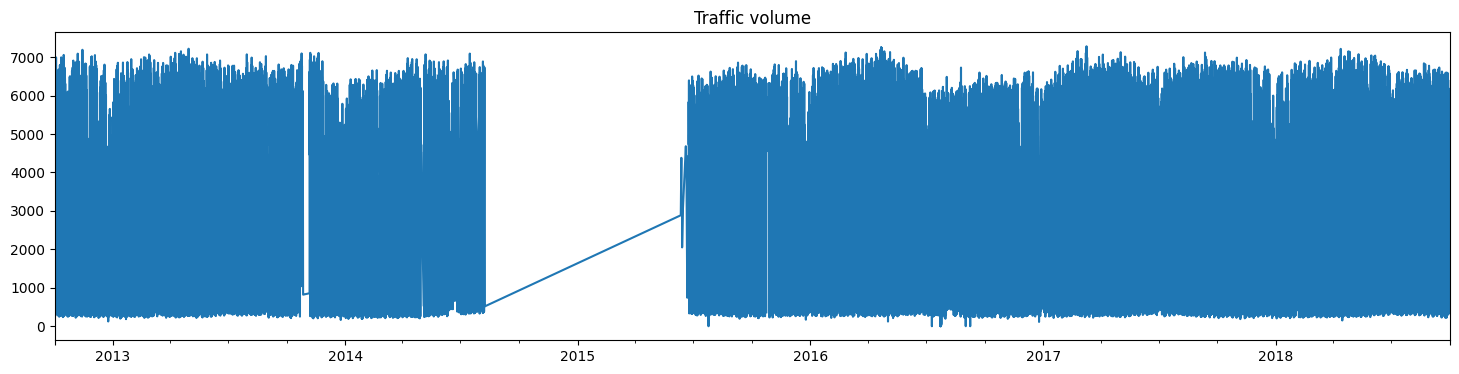

In [7]:
# Визуализация
df["traffic_volume"].plot(figsize=(18,4))
plt.title("Traffic volume")
plt.show()

В 2015 году есть длительный пробел в данных. Исключим данные до середины 2015 года, чтобы ряд был без существенных пробелов. На таком длительном интервале данных это не должно оказать существенного влияния на прогноз.

In [8]:
df = df['2015-07-01':]

На самом деле оставлю из выборки данные только за год. Иначе рассчеты очень долгие и не хватает памяти.

In [9]:
df = df['2018-01-01':]

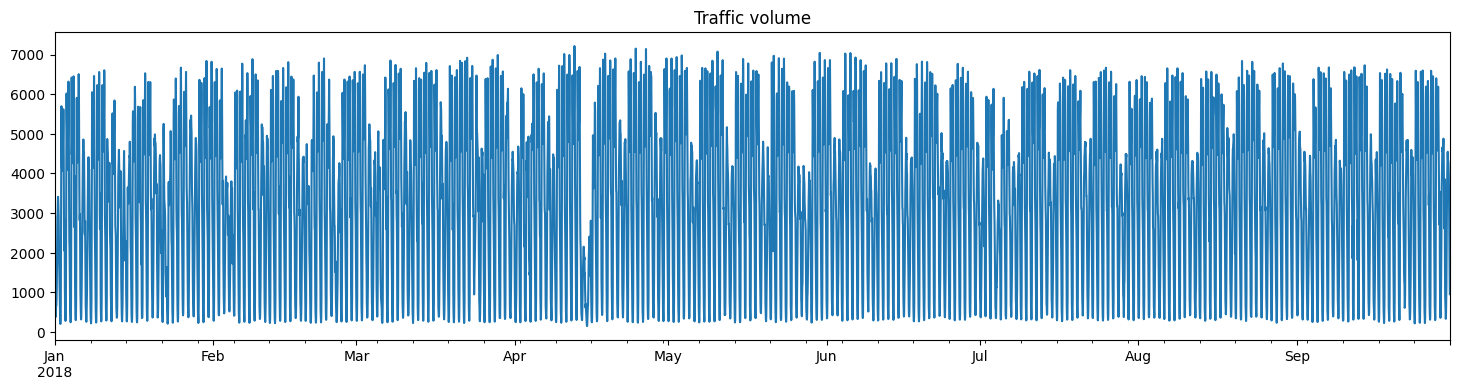

In [10]:
df["traffic_volume"].plot(figsize=(18,4))
plt.title("Traffic volume")
plt.show()

In [11]:
# Выборка по праздникам. Запись о них идет только одной строкой в полночь
df[df.holiday.notna()].head()

,traffic_volume,holiday,temp
2018-01-01,1478.0,New Years Day,249.360
2018-01-15,600.0,Martin Luther King Jr Day,262.540
2018-02-19,623.0,Washingtons Birthday,270.730
2018-05-28,1088.0,Memorial Day,299.487
2018-07-04,1021.0,Independence Day,297.550


### Признаки<a class="anchor" id="features">#</a>

**Даты**

Можно получить следующие признаки:

* день недели, 
* месяц,
* год,
* сезон,
* праздник,
* выходной,
* час.

In [12]:
# Дополнительные признаки: день недели и час дня
df["hour"] = df.index.hour                              # type: ignore
df["weekday"] = df.index.weekday                        # type: ignore
df["month"] = df.index.month                            # type: ignore
df["season"] = (df.index.month % 12) // 3               # type: ignore

# Выходные
df["weekend"] = np.where(df.index.weekday < 5, 0, 1)    # type: ignore

# Праздничные дни
df['date'] = df.index.date                              # type: ignore
holiday_dates = df.loc[df['holiday'].notna(), 'date'].unique()
df['is_holiday'] = df['date'].isin(holiday_dates)
df.drop(columns=['date'], inplace=True)

### Разложение ВР на компоненты<a class="anchor" id="decomp">#</a>

Первичный анализ с помощью seasonal_decompose

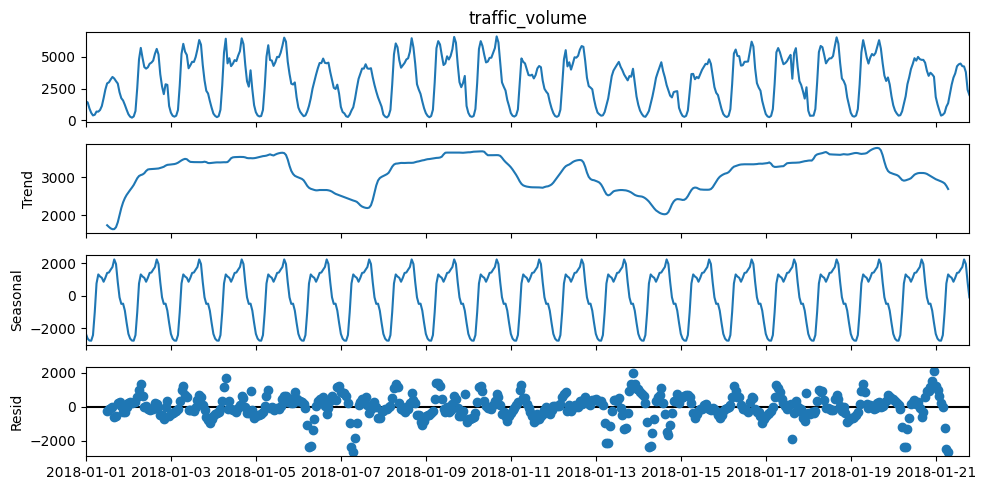

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(df['traffic_volume'][:500], model='additive', period = 24)
decompose.plot()

plt.show()

### Стационарность ВР<a class="anchor" id="stationary">#</a>

(Краткое обобщение GPT)

**Стационарность временного ряда** - это свойство ряда, при котором его статистические характеристики (среднее, дисперсия, автокорреляция) не меняются со временем.

Основные типы стационарности:

**1. Строгая стационарность**

* Распределение ряда не зависит от времени
* Все моменты распределения (среднее, дисперсия и т.д.) постоянны
* Редко встречается на практике

**2. Слабая стационарность (или стационарность в широком смысле)**

Три основных условия:

* Постоянное среднее: $E[Y_t] = \mu$ (константа, не зависит от $t$)
* Постоянная дисперсия: $Var(Y_t) = \sigma^2$ (константа, не зависит от $t$)
* Автоковариация зависит только от лага: $Cov(Y_t, T_{t+k}) = \gamma_k$ (зависит только от разницы во времени $k$, не от самого $t$)

**Визуальные признаки стационарности:**

**Стационарный ряд:**

* Колеблется вокруг постоянного среднего
* Амплитуда колебаний примерно одинаковая
* Нет тренда
* Нет сезонности


**Нестационарный ряд:**

* Есть восходящий или нисходящий тренд
* Меняется волатильность (дисперсия) со временем
* Есть сезонные паттерны

**Почему важна стационарность?**

1. Прогнозирование: Большинство моделей (ARIMA, SARIMA и др.) требуют стационарности
2. Интерпретация: Проще анализировать и делать выводы
3. Статистические тесты: Многие тесты предполагают стационарность

**Как проверить стационарность?**

**1. Визуально**

* График ряда
* График автокорреляционной функции (ACF)

**2. Статистические тесты**

* Тест Дики-Фуллера (ADF)

### Скользящие средние для выявления тренда и выбосов<a class="anchor" id="ma_trend">#</a>

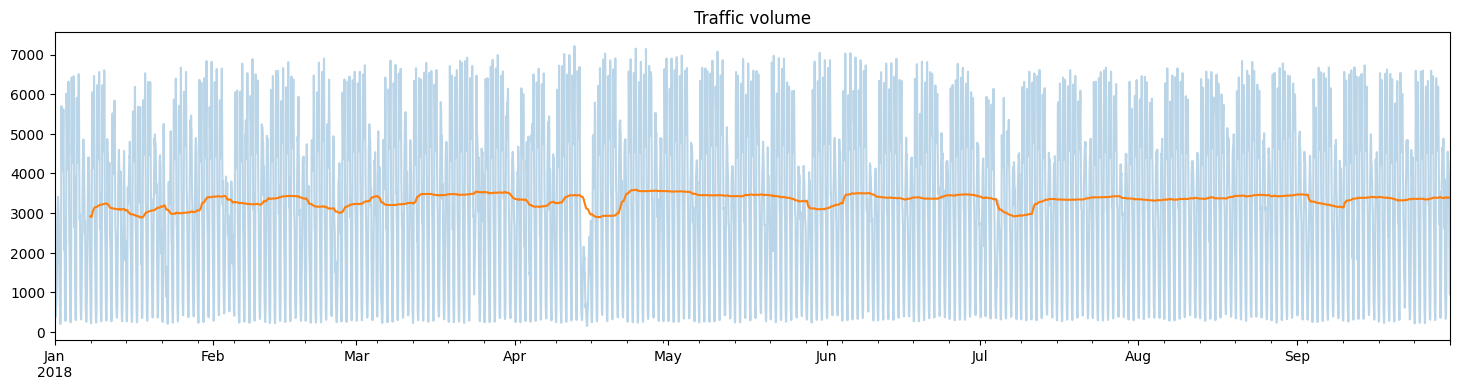

In [14]:
window = 168
scale = 1.3 #2.58 - 99%

df["SMA_avg"] = df["traffic_volume"].rolling(window=window).mean() # недельное сглаживание
# mae = mean_absolute_error(df["traffic_volume"][window:].fillna(0), df["traffic_volume"][window:].fillna(0))
mae = mean_absolute_error(df["traffic_volume"][window:].fillna(0), df["SMA_avg"][window:].fillna(0))
std = np.std(df["traffic_volume"][window:] - df["SMA_avg"][window:])
df["SMA_min"] = df["SMA_avg"] - (mae + scale * std)     # type: ignore
df["SMA_max"] = df["SMA_avg"] + (mae + scale * std)     # type: ignore

plt.figure(figsize=(18,4))

df["traffic_volume"].plot(label="Traffic volume", alpha=0.3)
df["SMA_avg"].plot(label="SMA")

anomaly_min = df[df['traffic_volume'] < df["SMA_min"]]
anomaly_max = df[df['traffic_volume'] > df["SMA_max"]]

plt.scatter(anomaly_min.index.values, anomaly_min['traffic_volume'], 
           color='red', s=30, label='Аномалии (минимум)', zorder=5)
plt.scatter(anomaly_max.index.values, anomaly_max['traffic_volume'], 
           color='orange', s=30, label='Аномалии (максимум)', zorder=5)

plt.title("Traffic volume")
plt.show()

**Вывод:** На графике не виден выраженный тренд. Аномалий тоже нет (величина доверительного интервала была сильно занижена, чтобы отобразить хоть какое-то подобие аномалии), есть только незначительные пропуски в статистике.

### Тест Дикки-Фуллера<a class="anchor" id="test_df">#</a>

Расширенный тест Дики-Фуллера (ADF) - это тип статистического теста, который определяет, присутствует ли единичный корень в данных временных рядов. 
Единичные корни могут привести к непредсказуемым результатам при анализе временных рядов. 
Нулевая гипотеза формируется в ходе теста на единичный корень, чтобы определить, насколько сильно тренд влияет на данные временных рядов. 
Принимая нулевую гипотезу, мы принимаем доказательства того, что данные временных рядов не являются стационарными. 
Отвергая нулевую гипотезу или принимая альтернативную гипотезу, мы подтверждаем, что данные временных рядов генерируются в результате стационарного процесса.

Если временной ряд имеет единичный корень, его можно сделать стационарным, применив дифференцирование — то есть вычитая текущее значение ряда из предыдущего.

In [15]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Расширенный тест Дики-Фуллера (ADF) : {column_name}')
    dftest = adfuller(series, autolag='AIC') # Информационный критерий Акаике
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Уровень значимости (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Вывод:====>")
        print("Принимаем нулевую гипотезу")
        print("Временной ряд стационарен")
    else:
        print("Вывод:====>")
        print("Отклоняем нулевую гипотезу")
        print("Временной ряд нестационарен")

Augmented_Dickey_Fuller_Test_func(df["traffic_volume"], "Traffic Volume")

Расширенный тест Дики-Фуллера (ADF) : Traffic Volume
Test Statistic                -1.063322e+01
p-value                        5.150454e-19
No Lags Used                   3.300000e+01
Number of observations used    6.518000e+03
Уровень значимости (1%)       -3.431354e+00
Уровень значимости (5%)       -2.861984e+00
Уровень значимости (10%)      -2.567006e+00
dtype: float64
Вывод:====>
Принимаем нулевую гипотезу
Временной ряд стационарен


**Вывод:** Временной ряд стационарен. Что очень удобно для дальнейших расчетов.

### ACF и PACF<a class="anchor" id="acf">#</a>

Предположим наличие разных циклов сезонности и построить несколько графиков автокорреляционной функции.

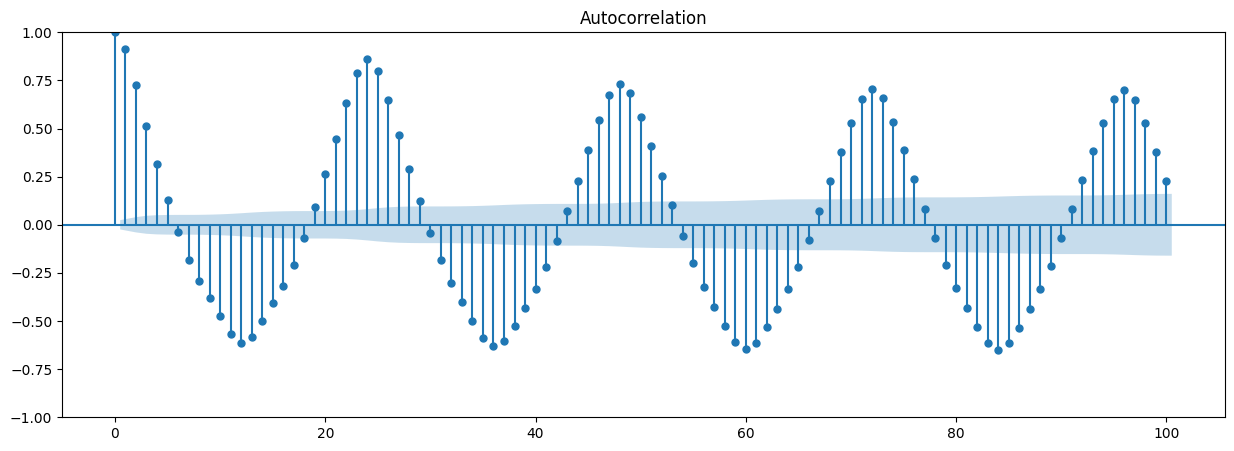

In [16]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
plot_acf(df['traffic_volume'], lags=100, ax=ax1)
plt.show()

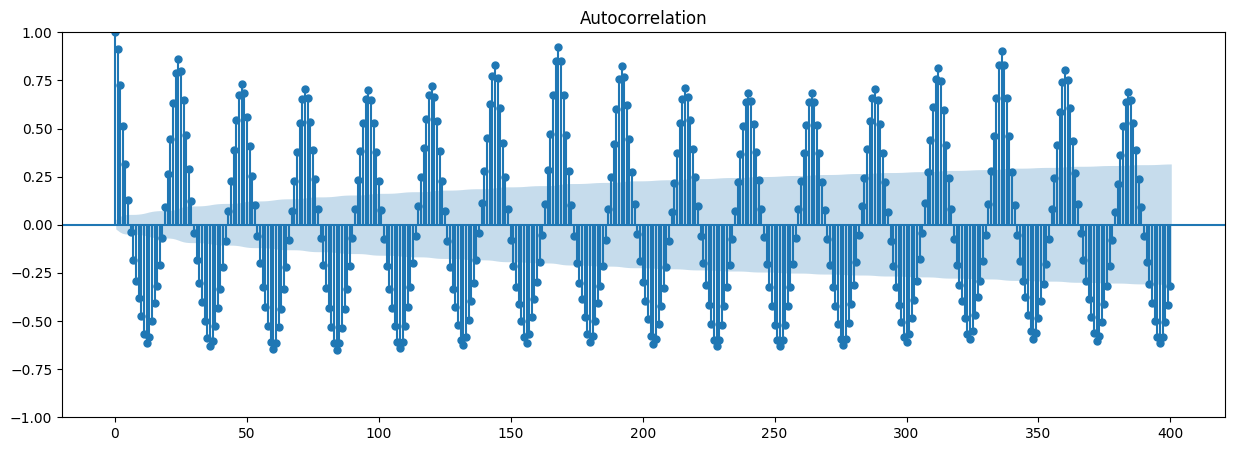

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
plot_acf(df['traffic_volume'], lags=400, ax=ax1)
plt.show()

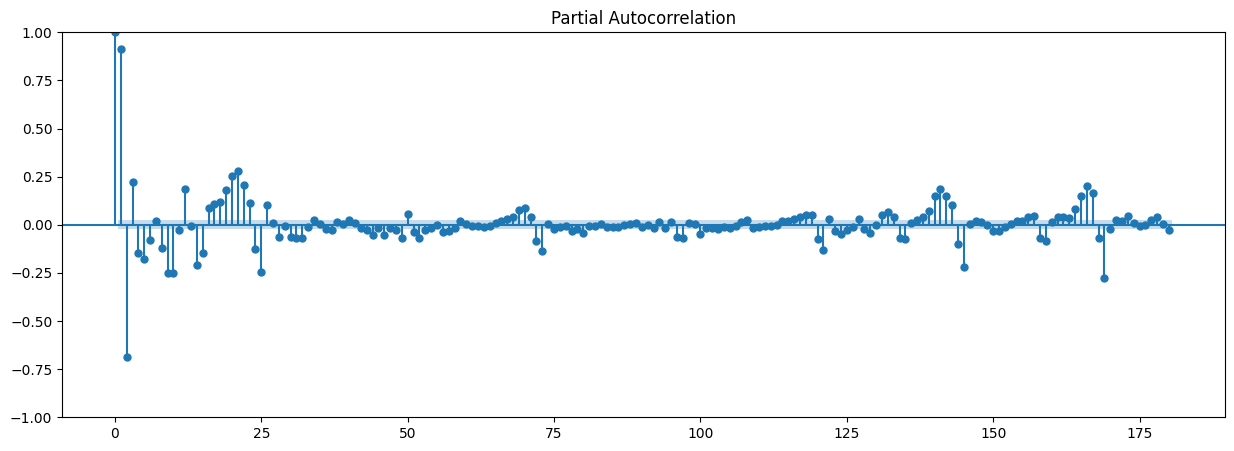

In [18]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
plot_pacf(df['traffic_volume'], lags=180, ax=ax1)
plt.show()

**Вывод:** График автокорреляционной функции (ACF) показывает, насколько значения ряда похожи сами на себя при сдвиге на разное количество шагов (лагов).

На графике ACF явно выражены 24-часовые суточные циклы. Менее ярко видны недельные циклы. Графики сильно автокоррелированы и содержат выраженную сезонность и цикличность.

На графике PACF видны сильная зависимость от первого лага. Текущий трафик почти такой же, как и часом раньше - поток меняется плавно. Второй лаг - сильная отрицательная зависимость. Возможно влияие час-пиков. Даьше зависимость резко снижается и местами выделяются слабые сезонные зависимости, которые были видны на ACF.

## Моделирование <a class="anchor" id="model">#</a>

### Разделение выборок <a class="anchor" id="train_test">#</a>

In [19]:
# Размер выборки предсказания: 2 недели = 24 * 14 = 336 часов
PREDICT_SIZE = 24 * 14

train = df.iloc[:-PREDICT_SIZE]
test = df.iloc[-PREDICT_SIZE:]

### Functions <a class="anchor" id="func">#</a>

In [20]:
# Calculate MAE and RMSE
def print_errors(y_p, y_t):
    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)

    print(f'    Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'                     R2: {r2:.2f}')

    return {'MAE': mae, 'RMSE': float(rmse), 'R2': r2}

In [21]:
def forecast_graph(model, exog=None):
    forecast = model.forecast(steps=PREDICT_SIZE, exog=exog)
    conf_int = model.get_forecast(steps=PREDICT_SIZE, exog=exog).conf_int()

    plt.figure(figsize=(15, 5))
    
    plt.plot(train["traffic_volume"][-500:], label='Обучающая выборка', color='blue')
    plt.plot(test["traffic_volume"], label='Тестовая выборка',  color='green')
    plt.plot(forecast, label='Forecast', color='red', linestyle='--')
    
    plt.fill_between(forecast.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='red', alpha=0.1, label='95% Доверительный интервал')

    plt.title("Forecast")
    plt.xlabel("Date")
    plt.ylabel("Traffic")
    plt.legend()
    plt.grid(True)
    
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    
    plt.show()

def stats_fc_graph(fc, name):
    plt.figure(figsize=(15, 5))

    plt.plot(train["traffic_volume"][-500:], label='Обучающая выборка', color='blue')
    plt.plot(test["traffic_volume"], label='Тестовая выборка',  color='green')
    plt.plot(fc[name], label='Forecast', color='red', linestyle='--')

    plt.fill_between(fc.index,
                    fc.iloc[:, 2],
                    fc.iloc[:, 3],
                    color='red', alpha=0.1, label='95% Доверительный интервал')

    plt.title("Forecast " + name)
    plt.xlabel("Date")
    plt.ylabel("Traffic")
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()

    plt.show()    

### Baseline model <a class="anchor" id="baseline">#</a>

За базовую модель возьмем прогноз по средним по-недельным часовым значениям трафика (по условию задачи)

In [22]:
baseline_model = train.groupby(["weekday", "hour"])["traffic_volume"].mean()
# построим baseline тестовоую выборку по интервалу предикта
baseline_test = []
for ts, row in test.iterrows():
    dow = ts.dayofweek  # type: ignore
    hr = ts.hour        # type: ignore
    baseline_test.append(baseline_model.loc[(dow,hr)])
    
baseline_pred = np.array(baseline_test)

len(baseline_pred) == PREDICT_SIZE

True

In [23]:
# Алиас для компактности
y_test = test["traffic_volume"].to_numpy()

### Метрики <a class="anchor" id="metrics">#</a>

Используем метрики MAE и RMSE. Это базовые метрики с которыми будем сравнивать дальнейшие модели.

In [24]:
# Метрики
ALL_METRICS = {}

BASE_MAE = mean_absolute_error(y_test, baseline_pred)
BASE_RMSE = np.sqrt(mean_squared_error(y_test, baseline_pred))
# Коэффициент детерминации - доля вариации, объяснённая моделью
BASE_R2 = r2_score(y_test, baseline_pred)
 
ALL_METRICS['Baseline'] = {
    'MAE': BASE_MAE,
    'RMSE': float(BASE_RMSE),
    'R2': BASE_R2,
}

print(f'    Mean Absolute Error: {BASE_MAE:.2f}')
print(f'Root Mean Squared Error: {BASE_RMSE:.2f}')
print(f'                    R^2: {BASE_R2:.2f}')

    Mean Absolute Error: 210.87
Root Mean Squared Error: 311.68
                    R^2: 0.97


### ARIMA (без сезонности)<a class="anchor" id="arima_base">#</a>

Параметры для $ARIMA (p,d,q)$ подберем по ACF и PACF.

* Ряд стационарный, значит d=0.
* PACF значимо отлична от нуля на первых 2 лагах, на лаге 3 становится незначимой, значит p=2.
* ACF медленно затухает, значит q=1 или 2

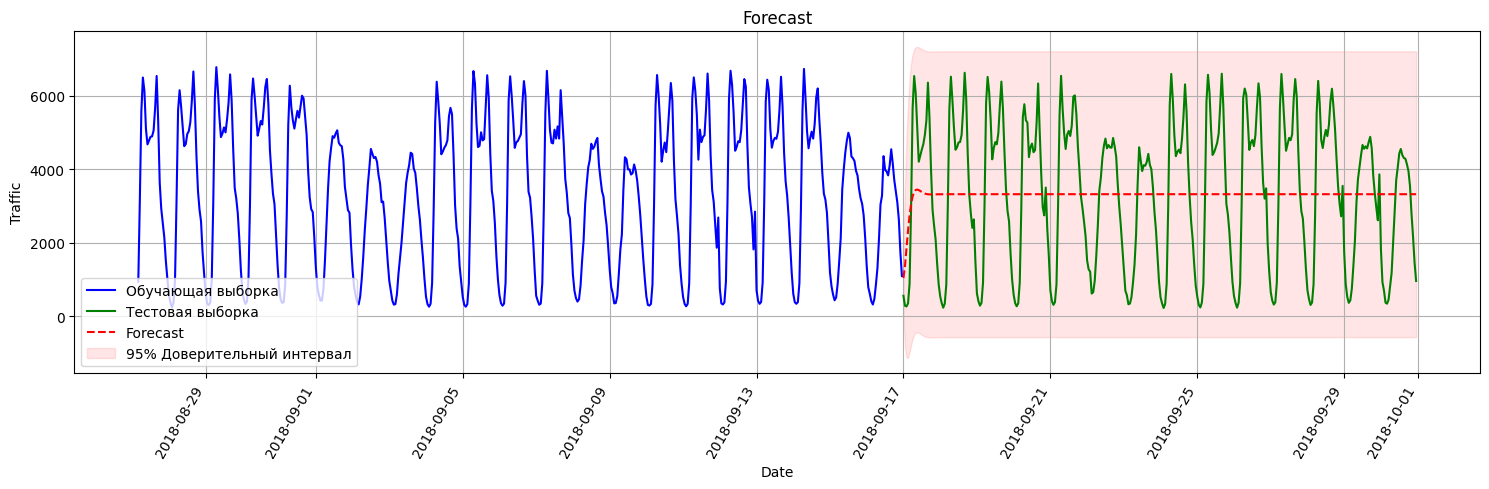

In [25]:
arima_base = ARIMA(train["traffic_volume"], order=(2, 0, 1)).fit()
forecast_graph(arima_base)

In [26]:
y_pred = arima_base.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)
ALL_METRICS['ARIMA'] = print_errors(y_pred, y_test)

    Mean Absolute Error: 1706.93
Root Mean Squared Error: 1939.49
                     R2: 0.02


In [27]:
# print(arima_base.params)
# print(arima_base.summary())

### Подбор оптимальных параметров для ARIMA<a class="anchor" id="arima_param">#</a>

Используя готовый пример из лекции, подберем оптимальные параметры для ARIMA

In [28]:
# Функция для подбора оптимальных параметров ARIMA по критерию Акаике
def find_best_arima(train_data, max_p=5, max_d=2, max_q=5):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_data, order=(p, d, q))
                    fitted_model = model.fit()

                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model

                    print(f'ARIMA({p},{d},{q}) - AIC: {fitted_model.aic:.2f}')

                except Exception as e:
                    continue

    print(f'\nЛучшая модель: ARIMA{best_order} с AIC: {best_aic:.2f}')
    return best_order, best_model

In [ ]:
best_order, best_model = find_best_arima(train["traffic_volume"])

В результате перебора наилучшее значение было у (4,0,4). Неожиданно. Проверим ошибку.

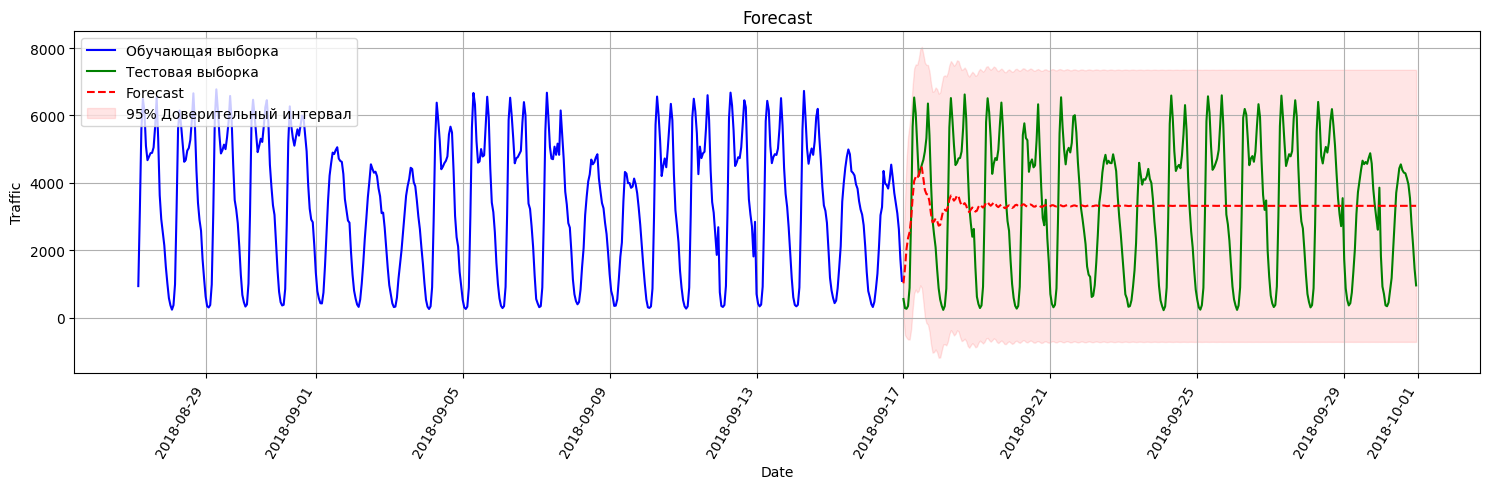

In [30]:
arima_404 = ARIMA(train["traffic_volume"], order=(4, 0, 4)).fit()

forecast_graph(arima_404)

In [31]:
y_pred = arima_404.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)

ALL_METRICS['ARIMA_best'] = print_errors(y_pred, y_test)

    Mean Absolute Error: 1667.46
Root Mean Squared Error: 1905.82
                     R2: 0.06


Оставляем значения (4,0,4)

### SARIMA. Сезонность 24 часа<a class="anchor" id="sarima_24">#</a>

Для сезонной составляющей укажем следующие значения:

* s=24 - это суточный лаг
* D=1 - это сколько раз мы берём разность с лагом s, суточная сезонность
* P и Q примем за 4 по аналогии с p и q. Логика странная, но значения метрик оказались лучше, чем у (1,1). При наличии времени оптимальные значения можно подобрать эксперементально.

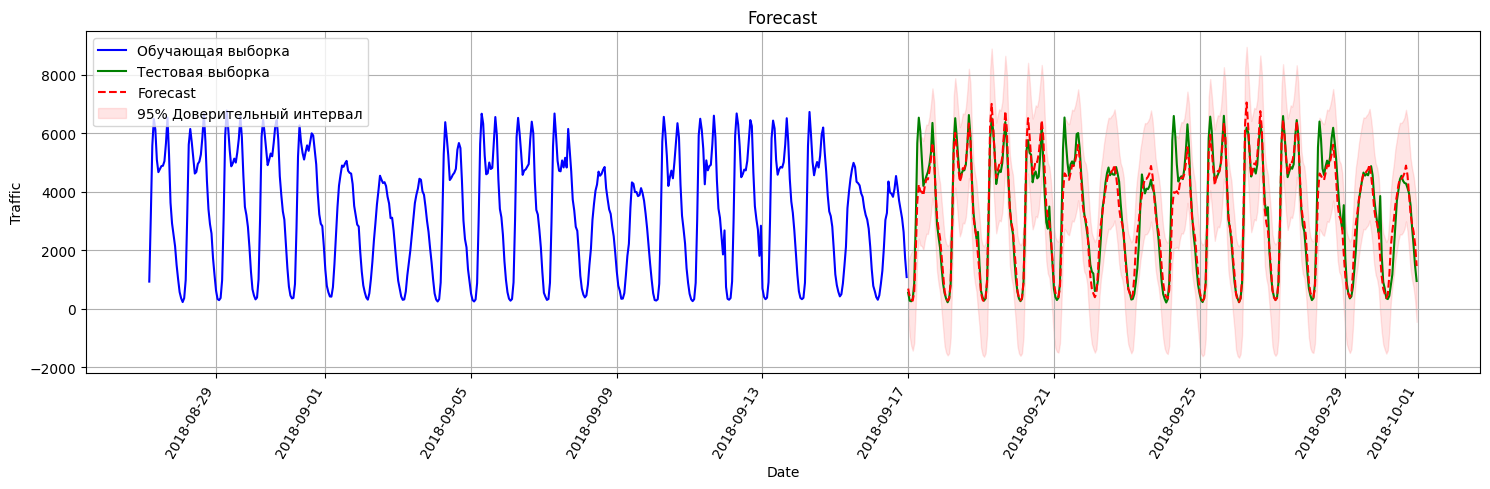

In [ ]:
sarima_24h = SARIMAX(
    train["traffic_volume"],
    order=(4,0,4),
    seasonal_order=(4,1,4,24)
).fit()

# Сохранение модели
# sarima_24h.save('sarima_24h_model.pkl')
# Загрузка модели
# sarima_24h = SARIMAXResults.load('sarima_24h_model.pkl')

forecast_graph(sarima_24h)

In [33]:
# print(sarima_24h.params)
# print(sarima_24h.summary())

In [34]:
y_pred = sarima_24h.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False)

ALL_METRICS['SARIMA'] = print_errors(y_pred, y_test)

    Mean Absolute Error: 340.71
Root Mean Squared Error: 540.43
                     R2: 0.92


### SARIMA. Сезонность 7 дней<a class="anchor" id="sarima_7d">#</a>

SARIMA не умеет учитывать сразу две компоненты сезонности. У нас есть суточные циклы и недельные. Проверим, какой прогноз получится на недельных циклах.

На таком интервале расчитать не получилось - не хватило ресурсов. 

In [35]:
# sarima_7days = SARIMAX(
#     train["traffic_volume"][-170:],
#     order=(4,0,4),
#     seasonal_order=(4,1,4,168)
# ).fit()
# forecast_graph(sarima_7days)

### SARIMAX. Экзогенный фактор<a class="anchor" id="sarimax">#</a>

Оценим влияние температуры на транспортный поток. Ожидаем, что в случае экстремальных температур, трафик должне изменяться.

In [36]:
# на всякий случай
df['temp'].isna().sum() == 0

np.True_

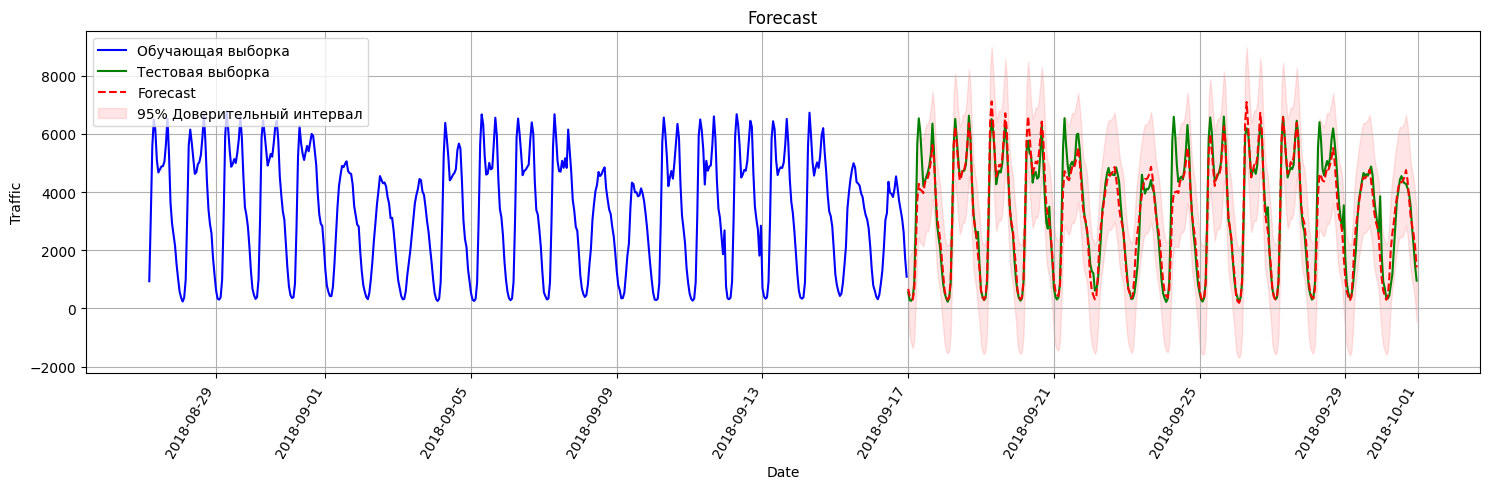

In [ ]:
sarima_exog = SARIMAX(
    train["traffic_volume"],
    exog=train[["temp"]],
    order=(4,0,4),
    seasonal_order=(4,1,4,24)
).fit()

# Сохранение модели
# sarima_exog.save('sarima_exog_model.pkl')
# Загрузка модели
# sarima_exog = SARIMAXResults.load('sarima_exog_model.pkl')

forecast_graph(sarima_exog, exog=test[["temp"]])

In [38]:
y_pred = sarima_exog.predict(start=len(train), end=len(train) + len(test)-1, dynamic=False, exog=test[["temp"]])

ALL_METRICS['SARIMAX'] = print_errors(y_pred, y_test)

    Mean Absolute Error: 341.68
Root Mean Squared Error: 536.54
                     R2: 0.93


### AutoARIMA<a class="anchor" id="auto_arima">#</a>

Чудный алгоритм ARIMA, который, судя по его описанию, сам подбирает значения коэффициентов, используя Akaike Information Criterion (AICc).

Для ускорения расчетов укажем ему делать грубую оценку через параметр "approximation=True".\
К сожалению, алгоритм не умеет работать с несколькими сезонностями, поэтому зададим ему бОльшую недельную сезонность параметром "season_length=168".\
Не забудем и про экзогенный фактор - temp.

In [39]:
# StatsForecast требует строго такой формат: unique_id, ds, y
df_sf = train[['traffic_volume', 'temp']].copy(deep=True)
df_sf.reset_index(inplace=True)
df_sf.rename(columns={'index': 'ds', 'traffic_volume': 'y'}, inplace=True)
df_sf["unique_id"] = "traffic"
df_sf.head()

,ds,y,temp,unique_id
0,2018-01-01 00:00:00,1478.0,249.36,traffic
1,2018-01-01 01:00:00,1408.0,249.08,traffic
2,2018-01-01 02:00:00,931.0,248.86,traffic
3,2018-01-01 03:00:00,585.0,248.72,traffic
4,2018-01-01 04:00:00,381.0,248.43,traffic


In [ ]:
sf = StatsForecast(
    models = [
        AutoARIMA(
            approximation=True,
            season_length=168
        )
    ],
    freq = 'H'
).fit(df_sf)

# Сохранение модели
# with open('sf_model.pkl', 'wb') as f:
#     pickle.dump(sf, f)
# Загрузка модели
# with open('sf_model.pkl', 'rb') as f:
#     sf = pickle.load(f)

In [41]:
future_sf = test[['temp']].copy(deep=True)
future_sf.reset_index(inplace=True)
future_sf.rename(columns={'index': 'ds'}, inplace=True)
future_sf["unique_id"] = "traffic"

forecast = sf.predict(h=len(future_sf), X_df=future_sf, level=[95])

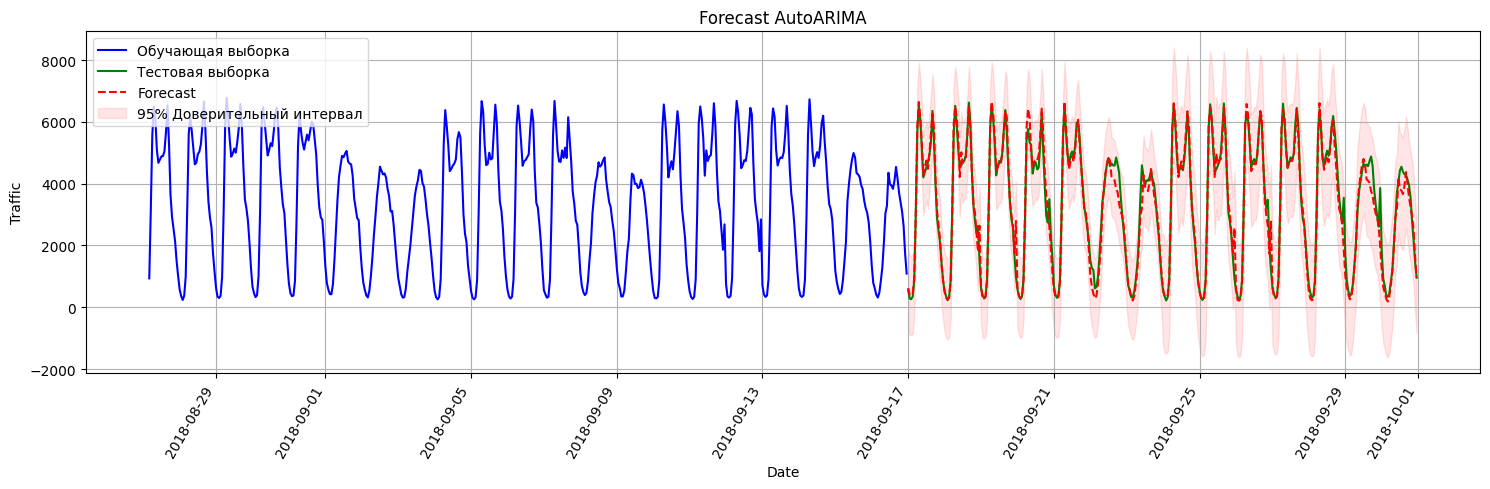

In [42]:
fc = forecast.set_index('ds')
stats_fc_graph(fc, 'AutoARIMA')

In [43]:
ALL_METRICS['AutoARIMAX'] = print_errors(fc['AutoARIMA'], y_test)

    Mean Absolute Error: 214.99
Root Mean Squared Error: 357.39
                     R2: 0.97


А теперь посмотрим на те коэффициенты, которые подобрал алгоритм.

In [44]:
arima_string(sf.fitted_[0,0].model_)

'Regression with ARIMA(5,0,3)(0,1,0)[168] errors'

А теперь посмотрим на коэффициенты AR (авторегрессии) и MA (скользящего среднего).

In [45]:
sf.fitted_[0,0].model_['coef']

{'ar1': np.float64(0.0),
 'ar2': np.float64(0.0),
 'ar3': np.float64(0.0),
 'ar4': np.float64(0.0),
 'ar5': np.float64(0.0),
 'ma1': np.float64(0.0),
 'ma2': np.float64(0.0),
 'ma3': np.float64(0.0),
 'drift': np.float64(0.024001717236417287),
 'ex_1': np.float64(8.459633221063799)}

Все AR = MR = 0. Результат необычный, потому что модель говорит, что у нее нет зависимости от прошлых значений (AR) и от прошлых ошибок (MA).\
Это означает, что $y_t$ не зависит от $y_{t-1}$, $y_{t-2}$ и т.д., а также не зависит от прошлых ошибок предсказания.\
При этом фактор температуры коррелирует с целевой переменной.\
Модель не использовала историю ряда и даже сезонность, а просто взяла цель прогнозировать по температуре.

Это полезный образовательный опыт, но эту модель определенно нужно проверить в других условиях, а именно уберем апроксимацию и экзогенный фактор.

In [46]:
df_sfp = df_sf.drop(columns=['temp'])

In [ ]:
sfp = StatsForecast(
    models = [
        AutoARIMA(
            approximation=False,
            season_length=168
        )
    ],
    freq = 'H'
).fit(df_sfp)

# Сохранение модели
# with open('sfp_model.pkl', 'wb') as f:
    # pickle.dump(sfp, f)
# Загрузка модели
# with open('sfp_model.pkl', 'rb') as f:
#     sfp = pickle.load(f)   

In [48]:
arima_string(sfp.fitted_[0,0].model_)

'ARIMA(3,0,0)(0,1,0)[168]                   '

In [49]:
sfp.fitted_[0,0].model_['coef']

{'ar1': np.float64(0.9096523775430178),
 'ar2': np.float64(-0.09653548533661371),
 'ar3': np.float64(0.030219377995232197)}

Теперь модель превратилась в авторегрессию третьего порядка AR=3. После сезонного дифференцирования получилась формула модели:
$$z_t = \phi_1 z_{t-1} + \phi_2 z_{t-2} + \phi_3 z_{t-3} + \epsilon_t$$
где:
$$z_t = y_t - y_{t-168}$$
или полностью с коэффициентами:
$$y_t - y_{t-168} = 0.91(y_{t-1} - y_{t-169}) - 0.1(y_{t-2} - y_{t-170}) + 0.03(y_{t-3} - y_{t-171}) + \epsilon_t$$

Разберем остатки

In [50]:
res = sfp.fitted_[0,0].model_['residuals']
res

array([   1.47799734,    1.40799295,    0.93099029, ...,  189.88321328,
       -220.12079147,  -45.30089508], shape=(6216,))

Массив из 6216 значений, где $\epsilon_t ​= z_t - \hat{z}_t​$, $z_t = y_t - y_{t-168}$.

Остается проверить, эти остатки являются ли белым шумом?

In [51]:
print("Mean:", np.mean(res))
print("Std:", np.std(res))
print("Std:", np.std(df_sfp['y']))

Mean: 2.227576471079932
Std: 342.3018071306378
Std: 1976.1602779727093


Итого получается:

Матожидание 2 - это статичтически почти ноль. 

Доля объясненной дисперсии 
$$R^2 = 1 - \frac{342^2}{1976^2} = 0.97$$
То есть модель объясняет примерно 97% вариации ряда, что весьма неплохо. Другими словами, после удаления сезонности и учета AR(3) остается всего 3% необъясненной дисперсии.

Теперь проведем **Ljung–Box тест**

In [52]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(res, lags=[24, 168], return_df=True)
print(lb)

         lb_stat     lb_pvalue
24    201.294674  5.871804e-30
168  2075.369915  0.000000e+00


**p-value** для обоих логов сильно меньше 5%. Это означает, что остатки - это не только белый шум. Есть неучтенные факторы. Возможно экзогенные, так как фактор температуры в этой модели не был учтен.

Посмотрим на ACF остатков

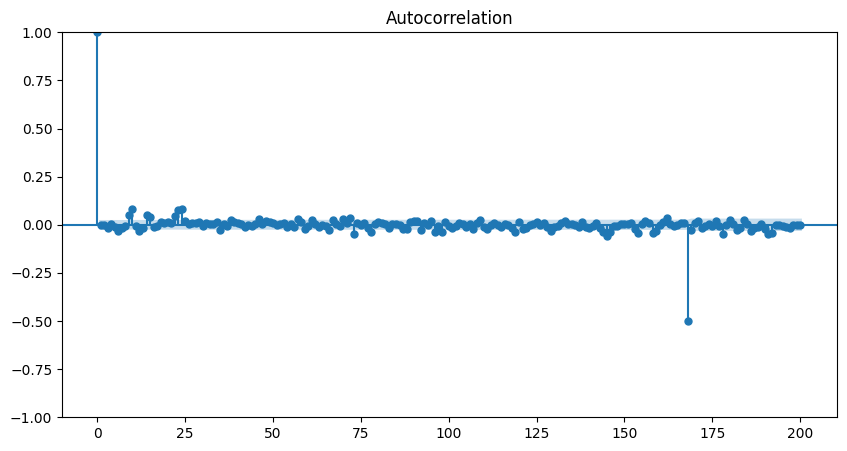

In [53]:
plot_acf(res, lags=200)
plt.show()

Пик на 168 лаге говорит о том, что недельная сезонность недоубрана. "Хороший" график должен быстро уходить в 0.

In [54]:
forecast = sfp.predict(h=len(future_sf), level=[95])

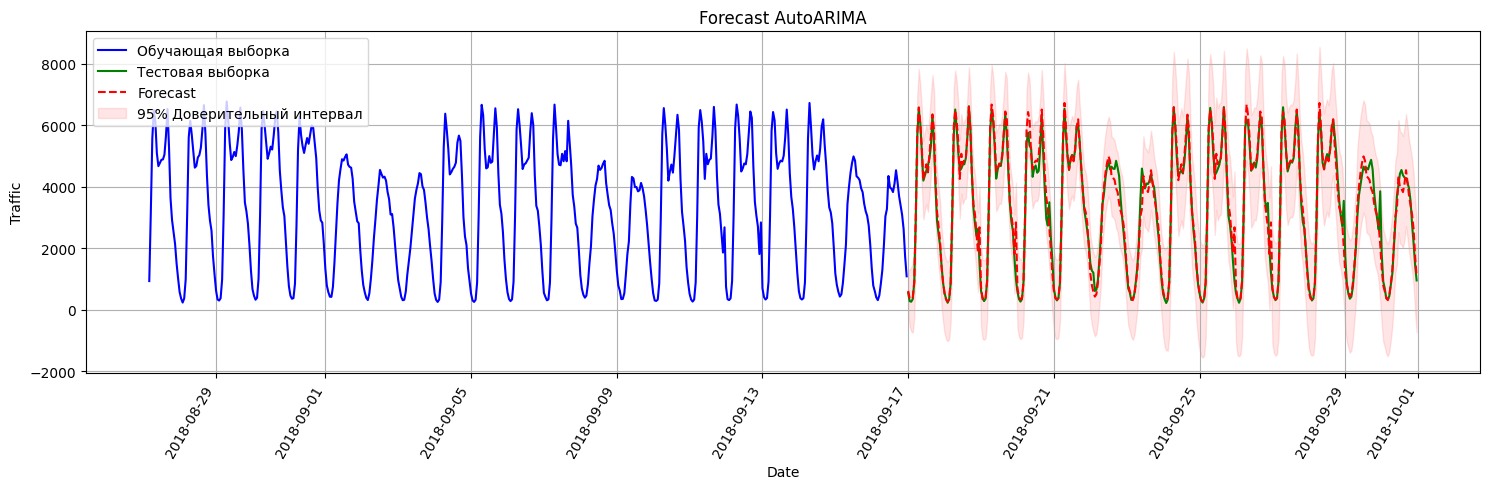

In [55]:
fc = forecast.set_index('ds')
stats_fc_graph(fc, 'AutoARIMA')

In [56]:
ALL_METRICS['AutoARIMAP'] = print_errors(fc['AutoARIMA'], y_test)

    Mean Absolute Error: 206.79
Root Mean Squared Error: 341.49
                     R2: 0.97


### AutoTBATS<a class="anchor" id="auto_tbats">#</a>

In [ ]:
sf_ab = StatsForecast(
    models = [AutoTBATS(season_length=[24,168])],
    freq = 'H',
    n_jobs=-1
).fit(df_sfp)

# Сохранение модели
# with open('sf_ab_model.pkl', 'wb') as f:
#     pickle.dump(sf_ab, f)
# Загрузка модели
# with open('sf_ab_model.pkl', 'rb') as f:
#     sf_ab = pickle.load(f)

In [58]:
forecast = sf_ab.predict(h=len(future_sf), level=[95])

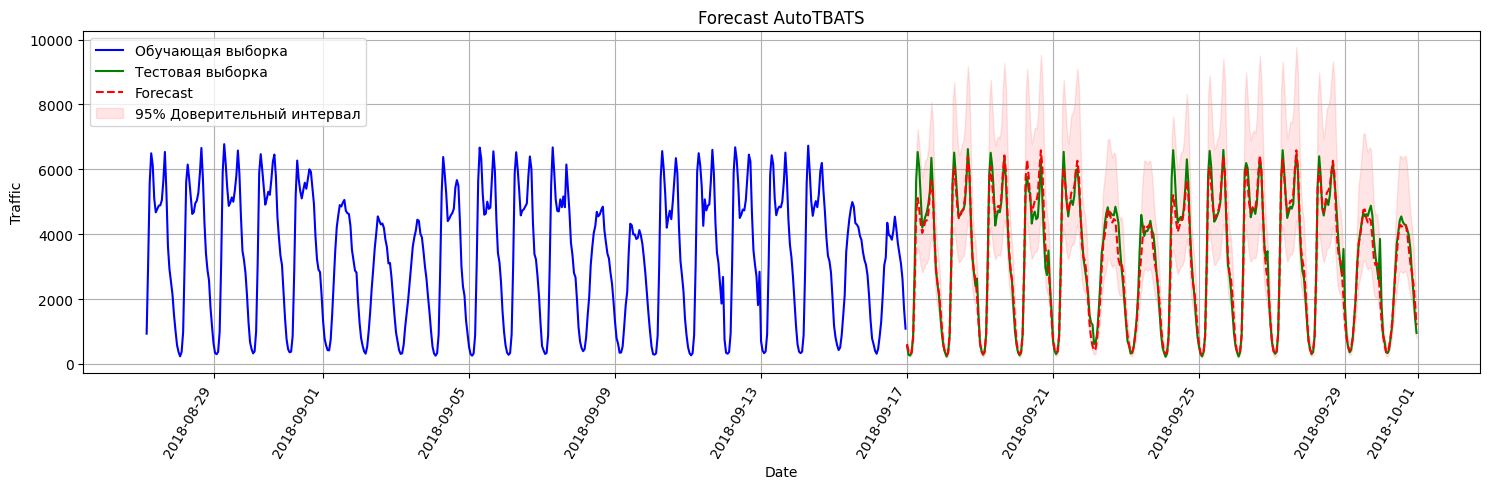

In [59]:
fc = forecast.set_index('ds')
stats_fc_graph(fc, 'AutoTBATS')

In [60]:
ALL_METRICS['AutoTBATS'] = print_errors(fc['AutoTBATS'], y_test)

    Mean Absolute Error: 232.67
Root Mean Squared Error: 351.52
                     R2: 0.97


### ETNA CatBoost<a class="anchor" id="etna_catboost">#</a>

In [61]:
etna_df = train[['traffic_volume', 'temp', 'is_holiday', 'weekday', 'month', 'season', 'weekend']].copy(deep=True).reset_index()
etna_df['segment'] = 'traffic'
etna_df = etna_df.rename(columns={'index':'timestamp', 'traffic_volume':'target'})
etna_df['is_holiday'] = etna_df['is_holiday'].astype(int)

etna_ds = TSDataset(etna_df, freq="H")
# Проверим, что нет пропусков
etna_ds.isnull().sum().sum()

np.int64(0)

In [62]:
etna_ds.head()

segment                traffic                                             
feature             is_holiday month season  target    temp weekday weekend
timestamp                                                                  
2018-01-01 00:00:00          1     1      0  1478.0  249.36       0       0
2018-01-01 01:00:00          1     1      0  1408.0  249.08       0       0
2018-01-01 02:00:00          1     1      0   931.0  248.86       0       0
2018-01-01 03:00:00          1     1      0   585.0  248.72       0       0
2018-01-01 04:00:00          1     1      0   381.0  248.43       0       0

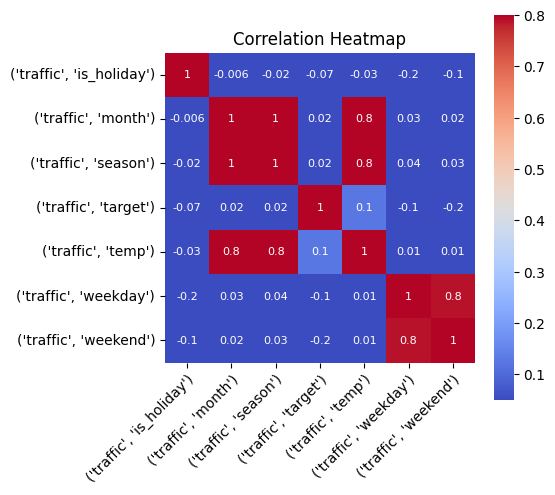

In [63]:
plot_correlation_matrix(etna_ds, method="pearson", vmin=0.05, vmax=0.8, figsize=(5,5), annot_kws={"size": 8}, cmap="coolwarm")

In [64]:
transforms = [
    # лаги: прошлые часы и сутки
    LagTransform(in_column='target', lags=[1,2,3,167,168,169], out_column="target_lag"), # Лаги уже известны после ARIMA
    MeanTransform(in_column='target', window=4, seasonality=168, out_column="weekly_mean"), # среднее пассажиров в этот же час за последние 7 недель
    FourierTransform(period=24, order=5, out_column="fourier_day"),
    FourierTransform(period=168, order=3, out_column="fourier_week"),
]

etna_ds.fit_transform(transforms)

# model = LinearPerSegmentModel()  # простая линейная модель на сегмент
model = CatBoostPerSegmentModel(
    iterations = 5000,
    depth = 4,
    learning_rate = None, # CatBoost сам подберет оптимальное значение
    task_type='GPU',
    devices='1' # Nvidia Tesla P100
)

pipeline = Pipeline(model=model, transforms=transforms, horizon=24)

In [65]:
backtest = pipeline.backtest(ts=etna_ds, metrics=[MAE(),RMSE()], n_folds=5)

metrics_df = backtest['metrics']
forecast_df = backtest['forecasts']

pipeline_metrics = metrics_df[["MAE", "RMSE", "fold_number"]].groupby('fold_number').mean()

print("Средние метрики по фолдам:", pipeline_metrics)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   52.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.6s


Средние метрики по фолдам:                      MAE         RMSE
fold_number                          
0            3339.788594  3946.673781
1            3239.772743  3858.840654
2            3312.240896  3887.815934
3            2392.052397  2848.713011
4            1956.404313  2445.953128


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


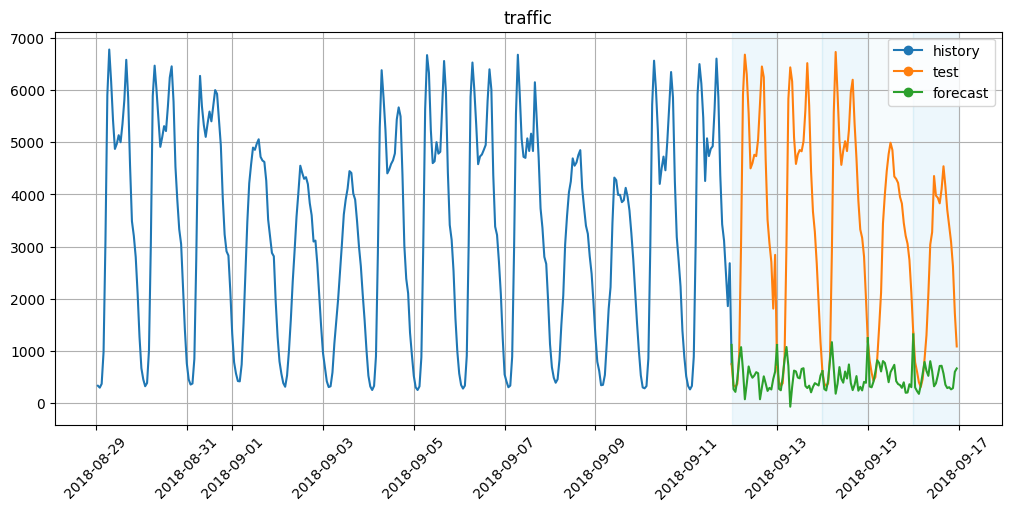

In [66]:
plot_backtest(forecast_df, etna_ds, history_len=24*14)

In [67]:
pipeline.fit(etna_ds)

Pipeline(model = CatBoostPerSegmentModel(iterations = 5000, depth = 4, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, task_type = 'GPU', devices = '1', ), transforms = [LagTransform(in_column = 'target', lags = [1, 2, 3, 167, 168, 169], out_column = 'target_lag', ), MeanTransform(in_column = 'target', window = 4, seasonality = 168, alpha = 1, min_periods = 1, fillna = 0, out_column = 'weekly_mean', ), FourierTransform(period = 24, order = 5, mods = None, out_column = 'fourier_day', in_column = None, ), FourierTransform(period = 168, order = 3, mods = None, out_column = 'fourier_week', in_column = None, )], horizon = 24, )

In [68]:
future_forecast = pipeline.forecast()
future_forecast_df = future_forecast.to_pandas(True)

Значения настолько ужасны (на графике даже видно), что смысла анализировать их дальше нет.

### ETNA TFTModel<a class="anchor" id="etna_tft">#</a>

In [233]:
target_df = df[['traffic_volume']].copy(deep=True).reset_index()
target_df['segment'] = 'traffic'
target_df = target_df.rename(columns={'index':'timestamp', 'traffic_volume':'target'})
target_df = TSDataset.to_dataset(target_df[:-PREDICT_SIZE])

regressor_df = df[['temp', 'weekday', 'is_holiday']].copy(deep=True).reset_index()
regressor_df['segment'] = 'traffic'
regressor_df = regressor_df.rename(columns={'index':'timestamp'})
regressor_df['is_holiday'] = regressor_df['is_holiday'].astype(int)
regressor_df = TSDataset.to_dataset(regressor_df)

etna_ds = TSDataset(df=target_df, freq="H", df_exog=regressor_df, known_future="all")
# Проверим, что нет пропусков
etna_ds.isnull().sum().sum()

np.int64(0)

In [234]:
HORIZON = PREDICT_SIZE

lags = [1,2,3,167,168,169]
lag_columns = [f"target_lag_{i}" for i in lags]
transform_lag = LagTransform(
    in_column="target",
    lags=lags,
    out_column="target_lag",
)

scaler = StandardScalerTransform(in_column=['target'])
encoder = SegmentEncoderTransform()

model_tft = TFTModel(
    encoder_length=4*HORIZON,
    decoder_length=HORIZON,
    static_categoricals=["segment_code"],
    time_varying_categoricals_encoder=['is_holiday', 'weekday'],
    time_varying_categoricals_decoder=['is_holiday', 'weekday'],
    time_varying_reals_encoder=['target', 'temp'] + lag_columns,
    time_varying_reals_decoder=['temp'], # + lag_columns,
    num_embeddings={'segment_code': 1, 'is_holiday': 2, 'weekday': 7},
    n_heads=2,
    num_layers=2,
    hidden_size=64,
    lr=0.001,
    train_batch_size=32,
    trainer_params=dict(max_epochs=10, gradient_clip_val=0.1, accelerator="gpu", devices=[0]),  # указываем индекс GPU
)
pipeline_tft = Pipeline(
    model=model_tft, horizon=HORIZON, transforms=[transform_lag, scaler, encoder]
)

In [235]:
backtest = pipeline_tft.backtest(etna_ds, metrics=[MAE(),RMSE()], aggregate_metrics=True, n_folds=3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                            ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                            │ MSELoss                  │      0 │ train │     0 │
│ 1  │ static_scalers                  │ ModuleDict               │      0 │ train │     0 │
│ 2  │ static_embeddings               │ ModuleDict               │    128 │ train │     0 │
│ 3  │ time_varying_scalers_encoder    │ ModuleDict               │  1.0 K │ train │     0 │
│ 4  │ time_varying_embeddings_encoder │ ModuleDict               │    704 │ train │     0 │
│ 5  │ time_varying_scalers_decoder    │ ModuleDict               │    128 │ train │     0 │
│ 6  │ time_varying_embeddings_decoder │ ModuleDict               │    704 │ train │     0 │
│ 7  │ static_variable_selection       │ VariableSelectionNetwork │ 25.3 K │ train │     0 │
│ 8  │ encoder_variable_selection      │ VariableSelectionNetwork │  1.0 M │ train │     0 │
│ 9  │ decoder_variable_selection      │ VariableSelectionNetwork │  138 K │ train │     0 │
│ 10 │ static_covariate_encoder        │ StaticCovariateEncoder   │ 67.1 K │ train │     0 │
│ 11 │ lstm_encoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 12 │ lstm_decoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 13 │ gated_norm1                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 14 │ temporal_fusion_decoder         │ TemporalFusionDecoder    │ 62.7 K │ train │     0 │
│ 15 │ gated_norm2                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 16 │ output_fc                       │ Linear                   │     65 │ train │     0 │
└────┴─────────────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 317                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.7min
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                            ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                            │ MSELoss                  │      0 │ train │     0 │
│ 1  │ static_scalers                  │ ModuleDict               │      0 │ train │     0 │
│ 2  │ static_embeddings               │ ModuleDict               │    128 │ train │     0 │
│ 3  │ time_varying_scalers_encoder    │ ModuleDict               │  1.0 K │ train │     0 │
│ 4  │ time_varying_embeddings_encoder │ ModuleDict               │    704 │ train │     0 │
│ 5  │ time_varying_scalers_decoder    │ ModuleDict               │    128 │ train │     0 │
│ 6  │ time_varying_embeddings_decoder │ ModuleDict               │    704 │ train │     0 │
│ 7  │ static_variable_selection       │ VariableSelectionNetwork │ 25.3 K │ train │     0 │
│ 8  │ encoder_variable_selection      │ VariableSelectionNetwork │  1.0 M │ train │     0 │
│ 9  │ decoder_variable_selection      │ VariableSelectionNetwork │  138 K │ train │     0 │
│ 10 │ static_covariate_encoder        │ StaticCovariateEncoder   │ 67.1 K │ train │     0 │
│ 11 │ lstm_encoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 12 │ lstm_decoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 13 │ gated_norm1                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 14 │ temporal_fusion_decoder         │ TemporalFusionDecoder    │ 62.7 K │ train │     0 │
│ 15 │ gated_norm2                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 16 │ output_fc                       │ Linear                   │     65 │ train │     0 │
└────┴─────────────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 317                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  7.7min
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                            ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                            │ MSELoss                  │      0 │ train │     0 │
│ 1  │ static_scalers                  │ ModuleDict               │      0 │ train │     0 │
│ 2  │ static_embeddings               │ ModuleDict               │    128 │ train │     0 │
│ 3  │ time_varying_scalers_encoder    │ ModuleDict               │  1.0 K │ train │     0 │
│ 4  │ time_varying_embeddings_encoder │ ModuleDict               │    704 │ train │     0 │
│ 5  │ time_varying_scalers_decoder    │ ModuleDict               │    128 │ train │     0 │
│ 6  │ time_varying_embeddings_decoder │ ModuleDict               │    704 │ train │     0 │
│ 7  │ static_variable_selection       │ VariableSelectionNetwork │ 25.3 K │ train │     0 │
│ 8  │ encoder_variable_selection      │ VariableSelectionNetwork │  1.0 M │ train │     0 │
│ 9  │ decoder_variable_selection      │ VariableSelectionNetwork │  138 K │ train │     0 │
│ 10 │ static_covariate_encoder        │ StaticCovariateEncoder   │ 67.1 K │ train │     0 │
│ 11 │ lstm_encoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 12 │ lstm_decoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 13 │ gated_norm1                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 14 │ temporal_fusion_decoder         │ TemporalFusionDecoder    │ 62.7 K │ train │     0 │
│ 15 │ gated_norm2                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 16 │ output_fc                       │ Linear                   │     65 │ train │     0 │
└────┴─────────────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 317                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.2min finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [236]:
metrics_df = backtest['metrics']
metrics_df

,segment,MAE,RMSE
0,traffic,241.567687,393.533029


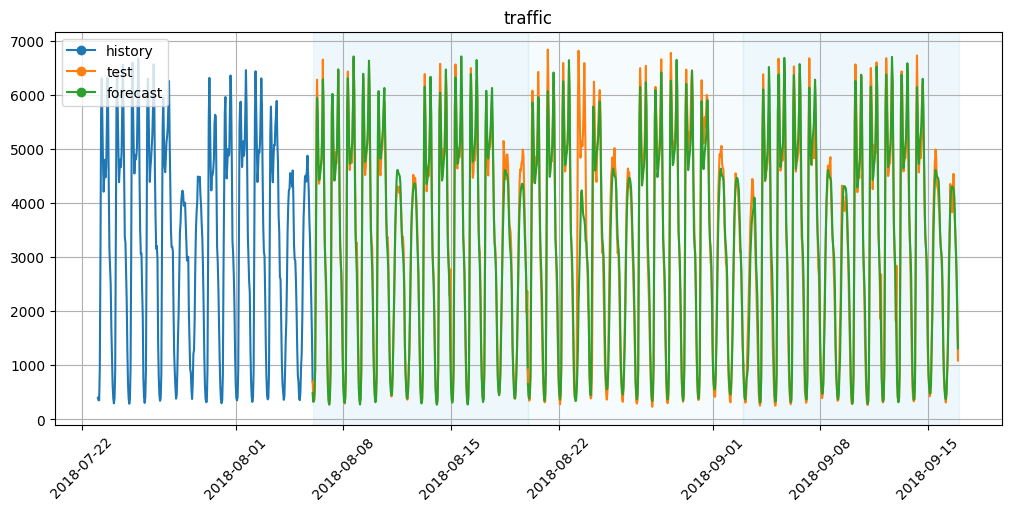

In [237]:
forecast_df = backtest["forecasts"]
plot_backtest(forecast_df, etna_ds, history_len=24*14)

In [238]:
pipeline_tft.fit(etna_ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                            ┃ Type                     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                            │ MSELoss                  │      0 │ train │     0 │
│ 1  │ static_scalers                  │ ModuleDict               │      0 │ train │     0 │
│ 2  │ static_embeddings               │ ModuleDict               │    128 │ train │     0 │
│ 3  │ time_varying_scalers_encoder    │ ModuleDict               │  1.0 K │ train │     0 │
│ 4  │ time_varying_embeddings_encoder │ ModuleDict               │    704 │ train │     0 │
│ 5  │ time_varying_scalers_decoder    │ ModuleDict               │    128 │ train │     0 │
│ 6  │ time_varying_embeddings_decoder │ ModuleDict               │    704 │ train │     0 │
│ 7  │ static_variable_selection       │ VariableSelectionNetwork │ 25.3 K │ train │     0 │
│ 8  │ encoder_variable_selection      │ VariableSelectionNetwork │  1.0 M │ train │     0 │
│ 9  │ decoder_variable_selection      │ VariableSelectionNetwork │  138 K │ train │     0 │
│ 10 │ static_covariate_encoder        │ StaticCovariateEncoder   │ 67.1 K │ train │     0 │
│ 11 │ lstm_encoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 12 │ lstm_decoder                    │ LSTM                     │ 66.6 K │ train │     0 │
│ 13 │ gated_norm1                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 14 │ temporal_fusion_decoder         │ TemporalFusionDecoder    │ 62.7 K │ train │     0 │
│ 15 │ gated_norm2                     │ GateAddNorm              │  8.4 K │ train │     0 │
│ 16 │ output_fc                       │ Linear                   │     65 │ train │     0 │
└────┴─────────────────────────────────┴──────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 317                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


Pipeline(model = TFTModel(encoder_length = 1344, decoder_length = 336, n_heads = 2, num_layers = 2, dropout = 0.1, hidden_size = 64, lr = 0.001, static_categoricals = ['segment_code'], static_reals = [], time_varying_categoricals_encoder = ['is_holiday', 'weekday'], time_varying_categoricals_decoder = ['is_holiday', 'weekday'], time_varying_reals_encoder = ['target', 'temp', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_167', 'target_lag_168', 'target_lag_169'], time_varying_reals_decoder = ['temp'], num_embeddings = {'segment_code': 1, 'is_holiday': 2, 'weekday': 7}, loss = MSELoss(), train_batch_size = 32, test_batch_size = 16, optimizer_params = None, trainer_params = {'max_epochs': 10, 'gradient_clip_val': 0.1, 'accelerator': 'gpu', 'devices': [0], 'logger': []}, train_dataloader_params = {}, test_dataloader_params = {}, val_dataloader_params = {}, split_params = {}, ), transforms = [LagTransform(in_column = 'target', lags = [1, 2, 3, 167, 168, 169], out_column = 'tar

In [ ]:
# pipeline_tft.save('model_etna_tft.pkl')

In [240]:
future_forecast = pipeline_tft.forecast(
    # prediction_interval=True # Пока без доверительного интервала из-за специфических настроек GPU
)
pdf = future_forecast.to_pandas(True).set_index(['timestamp'])
pdf = pdf[['target']]

In [231]:
ALL_METRICS['ETNA_TFTModel'] = print_errors(pdf['target'], y_test)

    Mean Absolute Error: 577.41
Root Mean Squared Error: 724.46
                     R2: 0.86


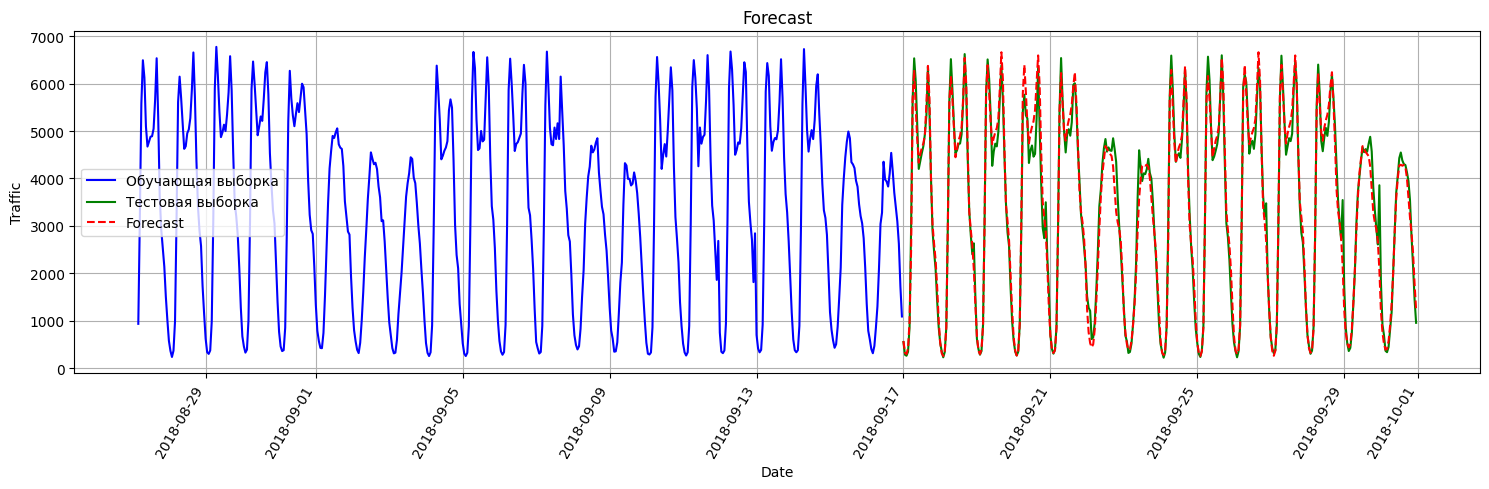

In [241]:
plt.figure(figsize=(15, 5))

plt.plot(train["traffic_volume"][-500:], label='Обучающая выборка', color='blue')
plt.plot(test["traffic_volume"], label='Тестовая выборка',  color='green')
plt.plot(pdf['target'], label='Forecast', color='red', linestyle='--')

# plt.fill_between(fc.index,
#                 fc.iloc[:, 2],
#                 fc.iloc[:, 3],
#                 color='red', alpha=0.1, label='95% Доверительный интервал')

plt.title("Forecast")
plt.xlabel("Date")
plt.ylabel("Traffic")
plt.legend()
plt.grid(True)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()

plt.show()

## Итог<a class="anchor" id="summary">#</a>

In [242]:
pd.DataFrame(ALL_METRICS).T

,MAE,RMSE,R2
Baseline,210.867255,311.678682,0.974784
ARIMA,1706.931763,1939.494575,0.023581
ARIMA_best,1667.458706,1905.819533,0.057194
SARIMA,340.710976,540.429900,0.924188
SARIMAX,341.676530,536.535641,0.925277
AutoARIMAX,214.987261,357.385470,0.966846
AutoARIMAP,206.790436,341.485258,0.969731
AutoTBATS,232.667500,351.520004,0.967926
ETNA_TFTModel,577.408394,724.455927,0.863767


Baseline прогноз оказался одним из самых надежных.\
Лучше всего показали себя модели с учетом сезонности: AutoARIMA, AutoTBATS, SARIMA(X). Скорее всего ETNA-TFT себя могла бы показать еще лучше, если ее более тонко настроить.